# Outlier Detection of 4 Digit MWC 4 Players using Tournament Scores using Box-Cox Transformation and Average Percentile Model

## Introduction

This notebook is the explanation and experimentation on an Alternative of Local Outlier Factor with a simpler model, which is an Average Percentile Model.

## Logit Transformation

**Logit Transformation** is a terminology to transform the score which are in range $[0, 1000000]$ into $(-\infty, \infty)$ using the formula

$$
\text{logit}(x) = \log(\frac{x}{1 - x})
$$

Where
$$
x = \frac{\text{score}}{1000000}
$$

This will also theoretically widen the gap between small difference of scores when the scores are higher. For example the difference between $\text{logit}(0.99) - \text{logit}(0.985)$ is less than $\text{logit}(0.995) - \text{logit}(0.99)$. Which matches the environment in the osu!mania tournament scene since the chance that the score gaps are low in earlier game is higher than the late game.

## Box-Cox Transformation

**Box-Cox Transformation** can be written as

$$
\text{boxcox}(x) = \begin{cases}
\frac{x^\lambda - 1}{\lambda} & \lambda \neq 0\\
\log(x) & \lambda = 0
\end{cases}
$$

Theoretically, the following transformation will make the data more Normally Distributed. We can find the $\lambda$ using **Maximum Likelihood** which will try to find the $\lambda$ that maximize how "Normally Distributed" the data is.

More information and experimentations can be found in [boxcox.ipynb](https://github.com/HowToProgramming/4dm4analysis/blob/main/boxcox.ipynb)

## Parametric Average Percentile Model

**Parametric Average Percentile Model** is based on the idea of how to measure the proportion of the population that a given player has surprassed. The data in this case is multi-dimensional data, that means there are multiple maps in the calculation process of this model. First we standardize the data of each map, then we calculate the **Cumulative Distribution Function** of **Normal Distribution** or any given parametric distribution, we will call that a percentile. After that we average the percentile and get the final result of a given player.

### Adjustments

#### Applying Box-Cox Transformation

As mentioned in the previous section about Box-Cox Transformation, we transform the Logit-Transformed data using Box-Cox transformation in order to use them in the **Parametric Average Percentile Model**. This will maximize the efficiency of the model, however there is a case where $\lambda < 0$ which we should aware of because the higher the score, the lower the transformed value is, we then use another adjustment

$$
\text{sign}(\lambda) = \begin{cases}
1 & \lambda \geq 0\\
-1 & \text{otherwise}
\end{cases}
$$

We multiply them with our standardized value and then use that value to calculate the **Cumulative Distribution Function** in order to catch that issue.

#### Applying Maps Played into the consideration

After we got the output from our Model, we then find another factor which the model didn't catch which is the "Maps Played". The important behaviour of outperformed players is the fact that they usually are main players of most of the maps. So we try to include this feature by multiplying the outlier value that we got from model with the log of maps played. Which is the following formula:

$$
\text{Adjusted Outlier Score} = \text{Outlier Value from Avg. Percentile} \cdot \log(\# \text{Maps Played} + 1)
$$

We then use this value to detect the outlier or outperformed players.

#### Applying Participation Rate into Consideration

Another way to evaluate whether a player should be skillbanned would be to consider the participation of a given player in a team. This can be thought as how much a player "sandbags" the team. The way to get the participation rate is to divide a player's score with a maximum team score in a given map.

But how do we prioritize which map should be considered more or less ? This is an important process in skillbanning because if we equally weighted every map, the model might not be reliable due to early game being equal to late game, so we do the following procedure:

- We obtain the participation rate using the method from a recent paragraph
- We calculate the "probability of elimination", means how many teams have been eliminated<!--294--> in a round that a given map is placed.
- We then combine two values together using multiplication and averaging for each round, then perform the summation to get a participation value.

The overall formula will be

$$
\text{Map Participation Rate} = \frac{\text{Player Score}}{\text{Team Score}} \cdot (\text{Probability of Elimination} + \epsilon)
$$

$$
\text{Overall Participation Rate} = \sum_{\text{round} \in \text{rounds}}  \text{Avg} (\text{Map Participation Rate})
$$

Then we combine them into outlier values using this formula:

$$
\text{Adjusted Outlier Values} = \left(1 + p\right)x
$$

Where $p$ is **Overall Participation Rate** and <br>
$x$ is **Outlier Value** from our Parametric Average Percentile Model

## In Layman Terms

"At the first instinct, the way to classify the outperforming players is to find the players who are outperforming." <p align="right">- HowToPlayLN, 2022, while thinking how to write this section</p>

But the more important question is, how do we define outperforming ? Given a player, an easy idea is to calculate how many players a given player has surpressed in a certain map. To be precise, we try to compare the player with the entire population of players who are eligible to participate in a tournament. In order to compare (approximate) directly, we need to use the statistical magic called "Normal Distribution".<p hidden=true>which there is no turning back if we commit it (sry overused joke)</p>

But we cannot use the Normal Distribution directly, from the raw score, we need to use some transformation to extract some features and normalize them. First, we use the "logit transformation" to seperate the stacked performances of players in the tournament, for example, we can see more distinction between 990k and 995k score than 985k and 990k, which matches the environment of how osu!mania tournaments usually works. Next, we use the "Box-Cox Transformation" in order to make data suitable for the statistical magic.

We then input the transformed data into the statistical magic that allows us to approximate how much the player has surprassed the population. However, we do this for every single map in a tournament and use all sample players data to determine the approximated value. Then we average the values for all maps a player played in a tournament.

Finally, the last feature comes from the nature of the behaviour of outperforming players in a tournament, especially a country team tournament with the format of 3v3 and 6 players for each country. They usually are the first or second player of the maps. With this information, we can add the "maps played" feature into the consideration. We do this by taking a logarithm function to maps played to reduce the difference between players who plays in the late game and focus more on them. We then multiply that value to the previous feature, then we get the numbers that will determine whether the player is outperforming.

## Code Documentation

In [1]:
import os

os.chdir("..")

### Importing Necessary Modules

We will use `pandas` for data management, `matplotlib.pyplot` for data visualization and `numpy` to deal with math stuff.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

For Local Packages, we will use `Dataset` and `get_table_players` to transform dataset into the 

In [3]:
from utils import Dataset
from utils.outlierdetectionmodel import BoxCoxParametricAveragePercent
from utils.dftransformer import get_table_players

In [4]:
_4dm4_dataset = Dataset('datasets/4dm4.db')

In [5]:
_4dm4_data = _4dm4_dataset.select('scores', columns=['player_name', 'round', 'beatmap_type', 'beatmap_tag', 'score_logit'], where={
    'beatmap_type': ['LN', 'RC', 'HB'],
})

In [6]:
_4dm4_data.head()

,player_name,round,beatmap_type,beatmap_tag,score_logit
0,drag_,Q,RC,1,3.922366
1,JPBenedictGame,Q,RC,1,4.792686
2,iVALORUS,Q,RC,1,2.952871
3,BL5,Q,RC,1,5.119073
4,-Tebo-,Q,RC,1,5.221730


In [7]:
player_table = get_table_players(_4dm4_data)

In [8]:
player_table

,Q_RC_1,Q_RC_2,Q_LN_1,Q_HB_1,RO32_RC_1,RO32_RC_4,RO32_RC_5,RO32_LN_3,RO32_HB_1,RO16_RC_1,...,GF_RC_7,GF_LN_2,GF_LN_3,GF_LN_4,GF_HB_1,GF_HB_2,GF_HB_3,SF_RC_2,SF_HB_3,GF_RC_3
drag_,3.922366,2.913464,3.310021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JPBenedictGame,4.792686,3.630805,3.143908,3.262931,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iVALORUS,2.952871,2.364221,1.976354,2.624503,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BL5,5.119073,2.868556,3.635748,3.548144,3.984893,3.215893,4.803535,4.269779,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Tebo-,5.221730,3.583254,3.915976,3.042808,5.207228,4.899665,5.370992,4.391723,5.008284,5.030982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oliverq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TheFunk,NaN,NaN,NaN,NaN,NaN,4.256847,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Herarudo,NaN,NaN,NaN,NaN,NaN,NaN,5.109978,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
[Antonio],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.711016,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
player_table[player_table <= 0] = np.nan

In [10]:
model = BoxCoxParametricAveragePercent()

model.fit(player_table.values)

In [11]:
df = pd.DataFrame(index=player_table.index)

df['outlier_values'] = model.predict(player_table.values)

In [12]:
df.sort_values(by='outlier_values', ascending=False).head(16)

,outlier_values
NotXbxx,0.938812
Paturages,0.808961
Micleak,0.802119
NifloX_,0.795386
Ricizus,0.779673
shokoha,0.754505
JayLye,0.739499
XN_The_XD,0.720398
Gray Hardrock,0.718346
Pluty,0.713545


In [13]:
df['n_maps_played'] = np.sum(pd.notna(player_table.values), axis=1)

In [14]:
df

,outlier_values,n_maps_played
drag_,0.210072,3
JPBenedictGame,0.369865,4
iVALORUS,0.043815,4
BL5,0.336032,8
-Tebo-,0.542988,17
...,...,...
oliverq,0.248482,7
TheFunk,0.365996,2
Herarudo,0.303336,2
[Antonio],0.076878,2


In [15]:
df['adjusted_ol_values_1'] = df['outlier_values'] * np.log(df['n_maps_played'] + 1)

In [16]:
df.sort_values(by='adjusted_ol_values_1', ascending=False).head(15)

,outlier_values,n_maps_played,adjusted_ol_values_1
shokoha,0.754505,50,2.966581
Micleak,0.802119,31,2.779934
Gray Hardrock,0.718346,45,2.750291
Lazereed,0.688086,41,2.571839
Ricizus,0.779673,26,2.569676
[LS]Byte,0.651652,44,2.480619
henryalexbr,0.638299,45,2.443816
JayLye,0.739499,26,2.437267
Keskidi,0.642740,43,2.432250
MisteurFR,0.691559,31,2.396761


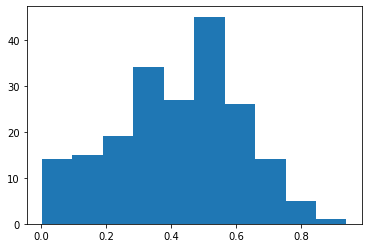

In [17]:
plt.hist(df['outlier_values'])
plt.show()

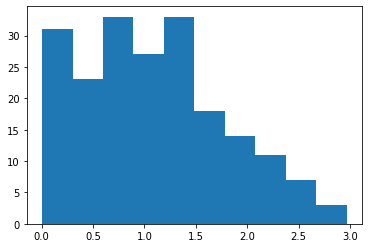

In [18]:
plt.hist(df['adjusted_ol_values_1'])
plt.show()

In [19]:
participation_rate_dataset = _4dm4_dataset.query("""select scores.player_name, scores.round, scores.beatmap_type, 
scores.beatmap_tag, scores.score as player_score, team_scores.score as team_score
from scores left join player_data on scores.player_name = player_data.player_name
left join team_data on team_data.country_code = player_data.country_code
left join team_scores on team_data.country_name = team_scores.country_name and
scores.beatmap_type = team_scores.beatmap_type and scores.round = team_scores.round and scores.beatmap_tag = team_scores.beatmap_tag
where scores.beatmap_type != \"SV\"""")

In [20]:
participation_rate_dataset

,player_name,round,beatmap_type,beatmap_tag,player_score,team_score
0,drag_,Q,RC,1,980590,2922767
1,JPBenedictGame,Q,RC,1,991778,2922767
2,iVALORUS,Q,RC,1,950399,2922767
3,BL5,Q,RC,1,994054,2974794
4,-Tebo-,Q,RC,1,994631,2974794
...,...,...,...,...,...,...
2760,MisteurFR,GF,TB,1,932066,2726756
2761,Gray Hardrock,GF,TB,1,908730,2726756
2762,--Pavin--,GF,TB,1,919303,2762098
2763,shokoha,GF,TB,1,910134,2762098


In [21]:
participation_rate_dataset['participation_rate'] = participation_rate_dataset['player_score'] / participation_rate_dataset['team_score']

In [22]:
participation_rate_dataset

,player_name,round,beatmap_type,beatmap_tag,player_score,team_score,participation_rate
0,drag_,Q,RC,1,980590,2922767,0.335501
1,JPBenedictGame,Q,RC,1,991778,2922767,0.339328
2,iVALORUS,Q,RC,1,950399,2922767,0.325171
3,BL5,Q,RC,1,994054,2974794,0.334159
4,-Tebo-,Q,RC,1,994631,2974794,0.334353
...,...,...,...,...,...,...,...
2760,MisteurFR,GF,TB,1,932066,2726756,0.341822
2761,Gray Hardrock,GF,TB,1,908730,2726756,0.333264
2762,--Pavin--,GF,TB,1,919303,2762098,0.332828
2763,shokoha,GF,TB,1,910134,2762098,0.329508


In [23]:
participation_rate_dataset = participation_rate_dataset[['player_name', 'round', 'participation_rate']]

In [24]:
average_participation_rate = participation_rate_dataset.groupby(['player_name', 'round']).mean()

In [25]:
average_participation_rate

participation_rate
player_name  round                    
--Pavin--    F                0.333310
             GF               0.336505
             Q                0.333664
             QF               0.333847
             RO32             0.333115
...                                ...
username1947 RO32             0.331001
wolfpup08    Q                0.335158
             QF               0.335978
             RO16             0.334961
             RO32             0.334334

[687 rows x 1 columns]

In [26]:
team_survived = _4dm4_dataset.query("""
SELECT last_round, count(country_name) from team_data where last_round != "" group by last_round 
""")

round_order = ["RO16", "QF", "SF", "F", "GF"]

In [27]:
team_survived

,last_round,count(country_name)
0,F,3
1,GF,3
2,Q,7
3,QF,12
4,RO16,8
5,SF,6


In [28]:
team_survived.index = team_survived['last_round']

In [29]:
team_survived = team_survived.loc[round_order]

In [30]:
team_survived

,last_round,count(country_name)
last_round,,
RO16,RO16,8
QF,QF,12
SF,SF,6
F,F,3
GF,GF,3


In [31]:
team_survived['country_eliminated'] = team_survived['count(country_name)'].cumsum()

In [32]:
team_survived

,last_round,count(country_name),country_eliminated
last_round,,,
RO16,RO16,8,8
QF,QF,12,20
SF,SF,6,26
F,F,3,29
GF,GF,3,32


In [33]:
team_survived['p_eliminated'] = team_survived['country_eliminated'] / 32

team_survived

,last_round,count(country_name),country_eliminated,p_eliminated
last_round,,,,
RO16,RO16,8,8,0.25000
QF,QF,12,20,0.62500
SF,SF,6,26,0.81250
F,F,3,29,0.90625
GF,GF,3,32,1.00000


In [34]:
average_participation_rate['multipiler'] = average_participation_rate.index.map(lambda x: team_survived[team_survived['last_round'] == x[1]]['p_eliminated'].values + 0.1 or [0.1])

C:\Users\HP\AppData\Local\Temp\ipykernel_240\844484177.py:1: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  average_participation_rate['multipiler'] = average_participation_rate.index.map(lambda x: team_survived[team_survived['last_round'] == x[1]]['p_eliminated'].values + 0.1 or [0.1])


In [35]:
average_participation_rate

participation_rate multipiler
player_name  round                               
--Pavin--    F                0.333310  [1.00625]
             GF               0.336505      [1.1]
             Q                0.333664      [0.1]
             QF               0.333847    [0.725]
             RO32             0.333115      [0.1]
...                                ...        ...
username1947 RO32             0.331001      [0.1]
wolfpup08    Q                0.335158      [0.1]
             QF               0.335978    [0.725]
             RO16             0.334961     [0.35]
             RO32             0.334334      [0.1]

[687 rows x 2 columns]

In [36]:
average_participation_rate['multipiler'] = average_participation_rate['multipiler'].apply(lambda x: x[0])

In [37]:
average_participation_rate['value'] = average_participation_rate['participation_rate'] * average_participation_rate['multipiler']

In [38]:
average_participation_rate

participation_rate  multipiler     value
player_name  round                                          
--Pavin--    F                0.333310     1.00625  0.335393
             GF               0.336505     1.10000  0.370156
             Q                0.333664     0.10000  0.033366
             QF               0.333847     0.72500  0.242039
             RO32             0.333115     0.10000  0.033311
...                                ...         ...       ...
username1947 RO32             0.331001     0.10000  0.033100
wolfpup08    Q                0.335158     0.10000  0.033516
             QF               0.335978     0.72500  0.243584
             RO16             0.334961     0.35000  0.117236
             RO32             0.334334     0.10000  0.033433

[687 rows x 3 columns]

In [39]:
average_participation_rate = average_participation_rate[['value']]

In [40]:
average_participation_rate = average_participation_rate.groupby(average_participation_rate.index.map(lambda x: x[0])).sum()

In [41]:
df

,outlier_values,n_maps_played,adjusted_ol_values_1
drag_,0.210072,3,0.291222
JPBenedictGame,0.369865,4,0.595274
iVALORUS,0.043815,4,0.070517
BL5,0.336032,8,0.738338
-Tebo-,0.542988,17,1.569436
...,...,...,...
oliverq,0.248482,7,0.516704
TheFunk,0.365996,2,0.402088
Herarudo,0.303336,2,0.333248
[Antonio],0.076878,2,0.084459


In [42]:
df['participation_value'] = average_participation_rate['value']

In [43]:
df

,outlier_values,n_maps_played,adjusted_ol_values_1,participation_value
drag_,0.210072,3,0.291222,0.033677
JPBenedictGame,0.369865,4,0.595274,0.034089
iVALORUS,0.043815,4,0.070517,0.032223
BL5,0.336032,8,0.738338,0.066566
-Tebo-,0.542988,17,1.569436,0.184402
...,...,...,...,...
oliverq,0.248482,7,0.516704,0.379694
TheFunk,0.365996,2,0.402088,0.033524
Herarudo,0.303336,2,0.333248,0.147141
[Antonio],0.076878,2,0.084459,0.033043


In [44]:
df['adjusted_ol_values_2'] = df['outlier_values'] + df['outlier_values'] * df['participation_value']

In [45]:
df.sort_values('adjusted_ol_values_2', ascending=False).head(10)

,outlier_values,n_maps_played,adjusted_ol_values_1,participation_value,adjusted_ol_values_2
shokoha,0.754505,50,2.966581,1.442786,1.843093
Gray Hardrock,0.718346,45,2.750291,1.431633,1.746755
MisteurFR,0.691559,31,2.396761,1.441007,1.688100
nanonbandusty,0.665679,27,2.218178,1.421859,1.612180
henryalexbr,0.638299,45,2.443816,1.445525,1.560975
Keskidi,0.642740,43,2.432250,1.428344,1.560794
--Pavin--,0.628328,32,2.196952,1.319672,1.457514
Lazereed,0.688086,41,2.571839,1.069906,1.424274
Micleak,0.802119,31,2.779934,0.736427,1.392822
[LS]Byte,0.651652,44,2.480619,1.076021,1.352843


---